# Dynamic Vaccination - Theoretical Model

## Imports and Functions Definition

In [1]:
from functions import *
import numpy as np
import networkx as nx

In [2]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:.2f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [13]:
def dyn_vax_theory(G,radius,Block,n_nodes,omega,beta,gamma,t_max):

    #here we store the probability of being in each of the 4 possible states at each time step
    MEAN_S = np.zeros(t_max+1) 
    MEAN_I = np.zeros(t_max+1)
    MEAN_R = np.zeros(t_max+1)
    MEAN_V = np.zeros(t_max+1)
    nodes_dict = {} #dict that will store for each node the corresponding values of variables phi, theta and delta defined in the paper

    #### population of the dictionary with info about the neighbors of each node ####
    for i in range(len(G.nodes)):
        tot_neigh = nx.single_source_shortest_path_length(G,i,radius) #get all neighbours within the given radis
        nth_neigh = set(key for key, value in tot_neigh.items() if value > 0 and value <= radius) if Block else set(key for key, value in tot_neigh.items() if value == radius) 
        
        nodes_dict[i] = {}
        nodes_dict[i]["first_neigh"] = {neigh:{"theta-t-1":1,"theta-t":1,"phi-t-1":1/n_nodes,"phi-t":1/n_nodes,"delta-t-1":1,"delta-t":1} for neigh in G.neighbors(i)}
        nodes_dict[i]["nth_neigh"] = {neigh:{"delta-t-1":1,"delta-t":1,"phi-t-1":1/n_nodes,"phi-t":1/n_nodes} for neigh in nth_neigh}

    ## initialization of the matrices ##
    MAT_S = np.zeros((n_nodes,t_max+1))
    MAT_S[:,0] = (n_nodes-1)/n_nodes
    MAT_R = np.zeros((n_nodes,t_max+1))
    MAT_I = np.zeros((n_nodes,t_max+1))
    MAT_I[:,0] = 1/n_nodes
    MAT_V = np.zeros((n_nodes,t_max+1))
    nodes_dict_copy = nodes_dict.copy()


    #### simulation of the epidemic ####
    t = 0

    while t < t_max:
        printProgressBar(t,t_max,prefix = "Time",suffix = "Complete",length = 50)
        for i in nodes_dict_copy.keys():
            for k in nodes_dict_copy[i]["first_neigh"].keys():
                nodes_dict_copy[i]["first_neigh"][k]["theta-t-1"] = nodes_dict_copy[i]["first_neigh"][k]["theta-t"]    
                nodes_dict_copy[i]["first_neigh"][k]["theta-t"] -= beta*(1-omega)*nodes_dict_copy[i]["first_neigh"][k]["phi-t"]
                nodes_dict_copy[i]["first_neigh"][k]["delta-t-1"] = nodes_dict_copy[i]["first_neigh"][k]["delta-t"]
                nodes_dict_copy[i]["first_neigh"][k]["delta-t"] -= omega*nodes_dict_copy[i]["first_neigh"][k]["phi-t"]
            
            for k in nodes_dict_copy[i]["nth_neigh"].keys():
                nodes_dict_copy[i]["nth_neigh"][k]["delta-t-1"] = nodes_dict_copy[i]["nth_neigh"][k]["delta-t"]
                nodes_dict_copy[i]["nth_neigh"][k]["delta-t"] -= omega*nodes_dict_copy[i]["nth_neigh"][k]["phi-t"]

        for i in nodes_dict_copy.keys():
            for k in nodes_dict_copy[i]["first_neigh"].keys():        
                save= nodes_dict_copy[i]["first_neigh"][k]["phi-t"]
                nodes_dict_copy[i]["first_neigh"][k]["phi-t"] = nodes_dict_copy[i]["first_neigh"][k]["phi-t-1"]*(1-gamma)*(1-beta)*(1-omega) + (MAT_S[i,0])*((np.prod([nodes_dict_copy[k]["first_neigh"][j]["theta-t-1"] for j in nodes_dict_copy[k]["first_neigh"].keys() if j!= i])-np.prod([nodes_dict_copy[k]["first_neigh"][j]["theta-t"] for j in nodes_dict_copy[k]["first_neigh"].keys() if j!= i]))*(np.prod([nodes_dict_copy[k]["first_neigh"][j]["delta-t"] for j in nodes_dict_copy[k]["first_neigh"].keys() if j!= i])))*(np.prod([nodes_dict_copy[k]["nth_neigh"][j]["delta-t"] for j in nodes_dict_copy[k]["nth_neigh"].keys() if j!= i]))
                nodes_dict_copy[i]["first_neigh"][k]["phi-t-1"] = save

        for i in nodes_dict_copy.keys():
            for k in nodes_dict_copy[i]["nth_neigh"].keys():        
                save= nodes_dict_copy[i]["nth_neigh"][k]["phi-t"]
                nodes_dict_copy[i]["nth_neigh"][k]["phi-t"] = nodes_dict_copy[i]["nth_neigh"][k]["phi-t-1"]*(1-gamma)*(1-beta)*(1-omega) + (MAT_S[i,0])*(np.prod([nodes_dict_copy[k]["first_neigh"][j]["theta-t-1"] for j in nodes_dict_copy[k]["first_neigh"].keys() if j!= i])-np.prod([nodes_dict_copy[k]["first_neigh"][j]["theta-t"] for j in nodes_dict_copy[k]["first_neigh"].keys() if j!= i]))*(np.prod([nodes_dict_copy[k]["nth_neigh"][j]["delta-t"] for j in nodes_dict_copy[k]["nth_neigh"].keys() if j!= i]))

                nodes_dict_copy[i]["nth_neigh"][k]["phi-t-1"] = save

        for i in nodes_dict_copy.keys():
                MAT_S[i,t] = MAT_S[i,0]*(np.prod([nodes_dict_copy[i]["first_neigh"][k]["theta-t"] for k in nodes_dict_copy[i]["first_neigh"].keys()]))*(np.prod([nodes_dict_copy[i]["nth_neigh"][k]["delta-t"] for k in nodes_dict_copy[i]["nth_neigh"].keys()]))
                MAT_R[i,t] = MAT_R[i,t-1] + gamma*MAT_I[i,t-1]
                MAT_I[i,t] = MAT_I[i,t-1]*(1-gamma) + (MAT_S[i,0])*(np.prod([nodes_dict_copy[i]["first_neigh"][j]["theta-t-1"] for j in nodes_dict_copy[i]["first_neigh"].keys() if j!= i])-np.prod([nodes_dict_copy[i]["first_neigh"][j]["theta-t"] for j in nodes_dict_copy[i]["first_neigh"].keys() if j!= i]))*(np.prod([nodes_dict_copy[i]["nth_neigh"][k]["delta-t"] for k in nodes_dict_copy[i]["nth_neigh"].keys()]))
                MAT_V[i,t] = 1-MAT_S[i,t]-MAT_I[i,t]-MAT_R[i,t]
        
    
        #print("t: "+str(t))
        MEAN_S[t] = np.mean(MAT_S[:,t])
        MEAN_I[t] = np.mean(MAT_I[:,t])
        MEAN_R[t] = np.mean(MAT_R[:,t])
        MEAN_V[t] = np.mean(MAT_V[:,t])
        t+=1


    #set mean_s[0] = 1

    return MEAN_S,MEAN_I,MEAN_R,MEAN_V

In [14]:
omega = 0.3 #vaccination probability
beta = 1 #infection probability
gamma = 1 #recovery probability
t_max = 50 #number of steps of the process
n_nodes = 10000 #number of nodes in the network
niter = 2 #number of iterations 
prob_vec = prob_list_powerlaw(2.5,3,400) #definition of the probability distribution of the network
radius = 2 #vaccination radius
Block = True #block or ring

In [15]:
S = [0]*t_max
I = [0]*t_max
R = [0]*t_max
V = [0]*t_max



iterat = 0
while iterat < niter:
    iterat += 1
    print("Iteration: "+str(iterat))


    ##### initialization of the graph #####
    degree_vec_in = discrete_samples(prob_vec,n_nodes)
    G = config_model(degree_vec_in)
    MEAN_S,MEAN_I,MEAN_R,MEAN_V = dyn_vax_theory(G,radius,Block,n_nodes,omega,beta,gamma,t_max)
    S = [S[i] + MEAN_S[i] for i in range(len(S))]
    I = [I[i] + MEAN_I[i] for i in range(len(I))]
    R = [R[i] + MEAN_R[i] for i in range(len(R))]
    V = [V[i] + MEAN_V[i] for i in range(len(V))]

S = [S[i]/niter for i in range(len(S))]
I = [I[i]/niter for i in range(len(I))]
R = [R[i]/niter for i in range(len(R))]
V = [V[i]/niter for i in range(len(V))]
     




Iteration: 1
Iteration: 2███████████████████████████████████████████-| 98.00% Complete


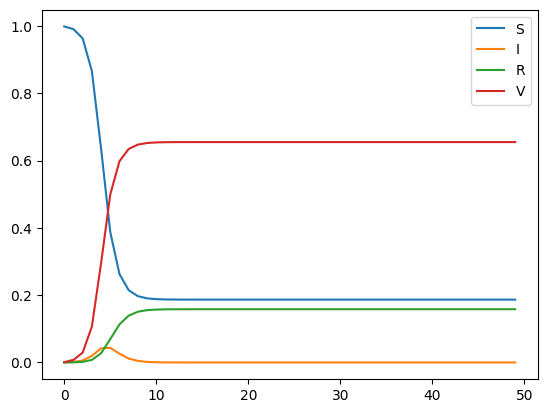

In [16]:
#plotting
import matplotlib.pyplot as plt
plt.plot(S,label = "S")
plt.plot(I,label = "I")
plt.plot(R,label = "R")
plt.plot(V,label = "V")
plt.legend()
plt.show()


In [ ]:
path = ""
Omega = np.linspace(0,0.4,100)
Beta = np.linspace(0,1,100)
import pandas as pd
df = pd.DataFrame(columns = ["Omega", "Beta", "time","Recovered", "Infected", "Susceptible", "Vaccinated"])
#save
df.to_csv(path+"results.csv")
for omega in Omega:
    for beta in Beta:
        iterat = 0
        S = [0]*t_max
        I = [0]*t_max
        R = [0]*t_max
        V = [0]*t_max
        while iterat < niter:
            iterat += 1
            print("Iteration: "+str(iterat))


            ##### initialization of the graph #####
            degree_vec_in = discrete_samples(prob_vec,n_nodes)
            G = config_model(degree_vec_in)
            MEAN_S,MEAN_I,MEAN_R,MEAN_V = dyn_vax_theory(G,radius,Block,n_nodes,omega,beta,gamma,t_max)

            S = [S[i] + MEAN_S[i] for i in range(len(S))]
            I = [I[i] + MEAN_I[i] for i in range(len(I))]
            R = [R[i] + MEAN_R[i] for i in range(len(R))]
            V = [V[i] + MEAN_V[i] for i in range(len(V))]

        S = [S[i]/niter for i in range(len(S))]
        I = [I[i]/niter for i in range(len(I))]
        R = [R[i]/niter for i in range(len(R))]
        V = [V[i]/niter for i in range(len(V))]
             
        
        #save
        for t in range(0,t_max):
            df = df._append({"Omega": omega, "Beta": beta, "time": t, "Recovered": MEAN_R[t], "Infected": MEAN_I[t], "Susceptible": MEAN_S[t], "Vaccinated": MEAN_V[t]}, ignore_index=True)

        print("Results for omega :"+str(omega)+", beta: "+str(beta)+ "::: +\n"+ "Recovered: "+str(R[-1])+"\n"+"Infected: "+str(I[-1])+"\n"+"Susceptible: "+str(S[-1])+"\n"+"Vaccinated: "+str(V[-1])+"\n")
        df.to_csv(path+"results.csv")


       